# Guidelines

This notebook is a template of what could be explored. You can follow it and explore  additional things.

Use the notebook to add your comments, figures, .... You can remove what you want and reorganize it as you wish. The goal is for you to make a nice report. The important points are to:
- understand what you will write
- explain the experimental results
- the code should be clean and well documented
- when you copy many times the same code, take the time to create a function instead.
- ideally, all the given text and code cells would be replaced by yours

# Autoencoders

An autoencoder (**AE**) is a special type of neural network that is trained to copy its input to its output. The key point is that between the input and output, there is a bottleneck: the dimension is reduced, and the information compressed.

For an input (image, time series, ... ),  the autoencoder first encodes it into a lower dimensional latent representation (the bottleneck), then decodes this latent representation go recover the original input. Of course, in the middle you have a compression of the information, and the task is not trivial. The encoder and decoder are usually a neural architecture adapted to the data and their structure: convolution, recurrent, .... In most of the case, the decoder is as symmetric as possible of the encoder, but it is not mandatory.

An autoencoder learns to compress the data while minimizing the reconstruction error. This is an example of unsupervised learning.  Autoencoder can be used to learn representation (the by product of the encoder), and to detect anomalies.



An autoencoder consists in two blocks:
- the encoder takes the input and projects it in a latent space of "reduced" dimension (in comparison with the input).
- the decoder maps some latent representation back in the input space.
You can see these two steps as a compression and decompression.

Basically, if you consider an input $\mathbf{x}$ :
$$\mathbf{z} = encoder(\mathbf{x})$$
$$\mathbf{\tilde{x}} = decoder(\mathbf{z})$$

The goal is to train the AE. The goal is to minimize the reconstruction error. This error can be defined as the mean square error  :
$$\min||\mathbf{\tilde{x}}-\mathbf{x}||^2$$

For this lab session, you will work with time series. One time serie is an electrocardiogram or ECG for short. It measures the electrical activities of the heart.
Each ECG corresponds to an extracted heartbeat containing 140 points and has been labelled as normal or being indicative of heart conditions related to congestive heart failure.

The goal is:
- from a set of ECGs (training set), we will train and AE on normal signals;
- and try to detect anomalies on unseen ECGs (test set) which contains normal and anormal ECGs.


## Anomaly detection

Autoencoders can learn to represent the data in a latent representation space and to reconstruct the data from this compressed representation. One possible application of AE is anomaly detection. The method is simple:
- if you encode and decode an input similar to the training data, the reconstruction loss should be low, while
- if you do the same with an input that differs from the training set, the loss should be higher (the model will fail to recontruct something similar).

Assume we have a  dataset. In our, case we consider only the training ECGs that are normal. Then we want to detect anomalies in the test set. The AE is a simple yet efficient tool to achieve anomaly detection. The reconstruction error should be high if it is an anomalie and low otherwise. Basically, we need to define a threshold on the reconstruction error to decide whether the input is an anomaly or not.


Before experimenting these kind of applications. Let us build and explore AEs.


# Initialization of session

imports and dataset.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

import torch as th
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn


# Download the dataset
PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
data.head()
data.info()


import warnings
warnings.filterwarnings("ignore") #REMOVING OF ALL WARNINGS


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


Look at the data, explore them to look what they look like. For instance, the last value (number 140):


In [ ]:
TARGET=140  # The last (141'st) value is in fact the class.
            # 1 for normal / 0 for bad ones

features = data.drop(TARGET, axis=1) #Removing the column 140 (labels)
target = data[TARGET]


# With SKlearn, do a split in test and train
all_x_train, all_x_test, all_y_train, all_y_test = train_test_split(
    features, # x data
    target,  # y data
    test_size = 0.2, # Represents the proportion of the dataset to include in the test split (20%)
    stratify = target #data is split in a stratified fashion (which creates splits by preserving the same percentage for each target class as in the complete set), using this as the class labels.
)


all_x_train = th.from_numpy(all_x_train.to_numpy())
all_x_test = th.from_numpy(all_x_test.to_numpy())
all_y_train = th.from_numpy(all_y_train.to_numpy())
all_y_test = th.from_numpy(all_y_test.to_numpy())
# The use case is anomaly detection so use only the normal data

# for training
good_idx = [all_y_train == 1]
bad_idx  = [all_y_train == 0]
x_train = all_x_train[good_idx]
bad_x_train   = all_x_train[bad_idx]
#for validation
good_idx = [all_y_test == 1]
bad_idx  = [all_y_test == 0]
good_x_test = all_x_test[good_idx]
bad_x_test   = all_x_test[bad_idx]

# min max scale the input data
min_max_scaler = MinMaxScaler(feature_range=(-1, 1)) # min and max values in the normalisation
x_train = min_max_scaler.fit_transform(x_train)
bad_x_train = min_max_scaler.transform(bad_x_train)
x_test = min_max_scaler.transform(all_x_test)
good_x_test = min_max_scaler.transform(good_x_test)
bad_x_test = min_max_scaler.transform(bad_x_test)

#We convert from numpy to tensor and we make a re-shape to specify 1-channel float type data set (Important for convolutions)

x_train = th.from_numpy(x_train).float().view(-1,1,140)
bad_x_train = th.from_numpy(bad_x_train).float().view(-1,1,140)
x_test = th.from_numpy(x_test).float().view(-1,1,140)
y_test = all_y_test.float()
good_x_test = th.from_numpy(good_x_test).float().view(-1,1,140)
bad_x_test = th.from_numpy(bad_x_test).float().view(-1,1,140)


print(x_test.shape)
print(y_test.shape)



torch.Size([1000, 1, 140])
torch.Size([1000])


We can plot some signals to see what they look like (normal and not normal)

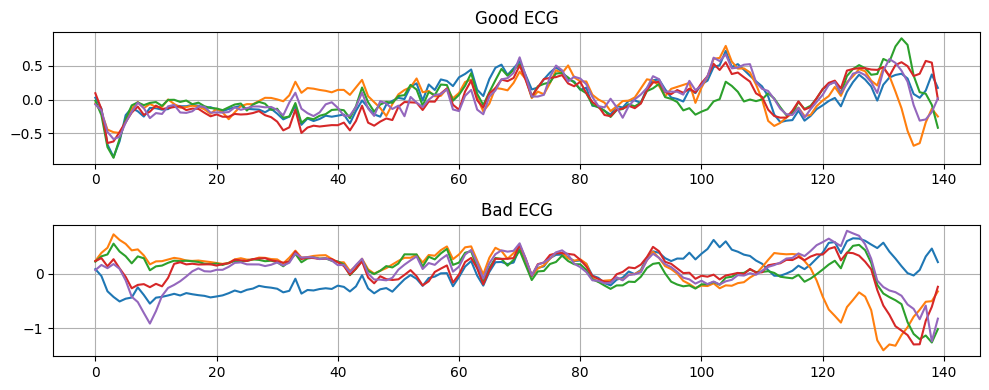

In [ ]:
n = 5
I , J  = 0,n
fig, axs = plt.subplots(2,1,figsize = (10, 4),tight_layout = True) # increase the vertical space to better see the title
for i in range(I,J):
    axs[0].plot(x_train[i].squeeze())
    axs[1].plot(bad_x_train[i].squeeze())
    axs[0].grid("minor")
    axs[1].grid("minor")
_ = axs[0].set_title("Good ECG")
_ = axs[1].set_title("Bad ECG")

# First try : Simple Auto-encoder

The basic idea is to have a linear transformation followed by a non-linearity for both the encoder and decoder. Here it is possible, since all the time series are of the same length.

Some questions remain:
- For the output activation, what can we use as function ?
- Find the adapted loss (as define above).
- The only hyperparameter on the architecture is the dimension of the latent space: $h$. Can you define the possible range of $h$ ?

**TODO** Write a class for the encoder and test it on some training data as sanity-check. The idea is to define a class where we will have two
"blocks": the encoder and the decoder.  The encoder is a simple Linear layer followed by a non-linearity (like Relu for instance). The decoder is also a Linear Layer but followed by an adapted activation. The important hyper-parameter here is $h$. It should be a parameter given to the constructor.


## Construction of the simple AE

Taking into account that the ECG is normalized with the limits [-1, 1], we set as the output activation function the hyperbolic tangent $(f = tanh(), f : R → [-1, 1] )$ which allows to have an output between the expected interval. The defined loss function $LF = \min||\mathbf{\tilde{x}}-\mathbf{x}||^2$, where $\tilde{x}$ is the reconstructed input (output of AE) and $\mathbf{x}$ is the input data; is imported from pytorch neural network module (pytorch.nn) as MSELoss (Medium Squared Error Loss).

We will set another layer in the encoder and encoder to have the following path:

#Encoder
- Linear layer followed by a non-linearity ReLu (N x 140 → N x h)
- Linear layer followed by a non-linearity Sigmoid (N x h → N x 2)

#Decorder
- Linear layer followed by a non-linearity Sigmoid (N x 2 → N x h)
- Linear layer followed by a tanh output activation function (N x h → N x 140)

This structure was chosen to have in the bottle neck an array of dimension 2 with the objective of use the encoder as a 2D projection function and see the representation of the data. However, the hidden-layers between the bottle neck and input/output will have an h-dimension that will help to do a first multidimensional projection in these layers and save as much information as possible. In ths AE, the hyper-parameter will be the hidden-layer dimension $h$.

In [ ]:
### write the class
class SimpleAE(nn.Module):
    # TODO :
    def __init__(self, h ):
        super(SimpleAE, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(140, h), nn.ReLU(),
                                     nn.Linear(h, 2), nn.Sigmoid())

        self.decoder = nn.Sequential(nn.Linear(2, h), nn.Sigmoid(),
                                     nn.Linear(h, 140), nn.Tanh())

    def forward(self,x) :
        return  self.decoder(self.encoder(x))

    def Encoder(self,x) :
        return  self.encoder(x)

loss_fn = nn.MSELoss() #Minimum Squared Error

**TODO** Write a function that train the autoencoder:
- for one model
- with some training data
- for some epochs
- with Adam and a tuneable learning rate.

In [ ]:
import time

def train_AE(model, epochs=30, lr=0.001, plot = False, verbose=False):

    optimizer = th.optim.Adam(model.parameters(),lr=lr)
    ### Mini-batching and shuffle
    Ntrain = x_train.shape[0]
    Nvalid = good_x_test.shape[0]
    ### store results
    train_losses,valid_losses = [],[]
    ########################
    # Training #############
    ########################

    start_time = time.time()

    for e in range(int(epochs+1)): #Iterations for-loop
        running_loss=0

        ECG_original = x_train #Input Data

        optimizer.zero_grad() #Re-initialisation of the gradient

        ECG_reconst = model(ECG_original) #Model's Output result

        loss = loss_fn(ECG_reconst,ECG_original) # Computing of the loss function

        loss.backward() #Backward learning (gradient descense)

        optimizer.step() #Optimizing parameters

        running_loss += loss.item()

        # training is over for one epoch

        # now we compute the validation loss
        with th.no_grad():
            model.eval()
            ECG_original = good_x_test
            ECG_reconst = model(ECG_original)
            valid_loss = loss_fn(ECG_reconst, ECG_original)
            valid_losses.append(100*valid_loss/Nvalid)
        model.train()
        train_losses.append(100*running_loss/Ntrain)

        if verbose:
            print("Epoch: {}\t".format(e+1),
                      "train Loss: {:.5f}.. ".format(train_losses[-1]),
                      "valid Loss: {:.5f}.. ".format(valid_losses[-1]))

    final_time = time.time()

    print("Run Time: {}\t".format(final_time-start_time))

    #########
    # plot ##
    #########
    if plot :
      fig, ax = plt.subplots(1,2,figsize = (8, 4),tight_layout = True)
      ax[0].plot(train_losses,'r')
      ax[0].set_ylabel(r" Train losses ", size=15)
      ax[0].set_xlabel(r" Epoch ", size=15)
      ax[0].grid('minor')
      ax[0].set_ylim(bottom=0)

      ax[1].plot(valid_losses,'r')
      ax[1].set_ylim(bottom=0)
      ax[1].set_ylabel(r" Valid losses ", size=15)
      ax[1].set_xlabel(r" Epoch ", size=15)
      ax[1].grid('minor')
      ax[1].set_ylim(bottom=0)

      plt.show()

    return train_losses

**TODO**:
- Then use this function to train the AE and look at some reconstructions to see the results. Start with a hidden dimension of $10$.
- Take the test set and look at the reconstruction error of normal ECGs and bad ones.
- Build an histogram of the reconstruction errors get on the test set:
    - both classes on the same histogram
    - two different colors for each class.
Given this histogram, can you guess the what could be the threshold and the expected error.

* Don't forget to try different value of the learning rate **for all the experiments now and after !**


RESULTS OF THE MODEL WITHOUT TRAINING


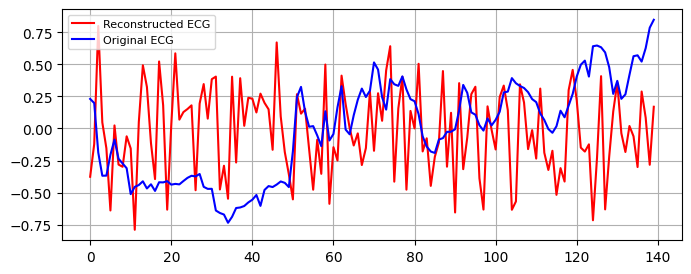

In [ ]:
# Testing the class
print("RESULTS OF THE MODEL WITHOUT TRAINING")
h = 10
module_SimpleAE = SimpleAE(h)
output = module_SimpleAE.forward(x_train[0])

fig, axs = plt.subplots(figsize = (8, 3))
axs.plot(output.squeeze().detach().numpy(), 'r', label = "Reconstructed ECG")
axs.plot(x_train[0].squeeze(), 'b', label = "Original ECG")
axs.grid("minor")
_ = axs.legend(fontsize = 8)


# Training and tunning process

First of all, we train the default SimpleAE to verify the convergence in the loss function and natural behaviour of the reconstructed output.


\Training results: 

Run Time: 1.8874967098236084	


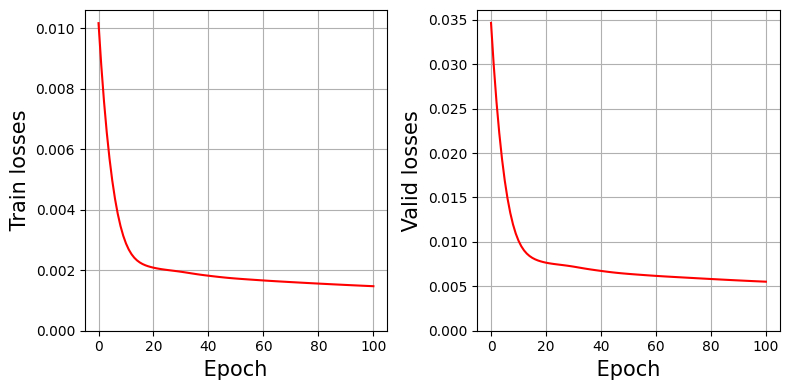


 Comparison between an input (ECG) and output (reconstructed ECG): 



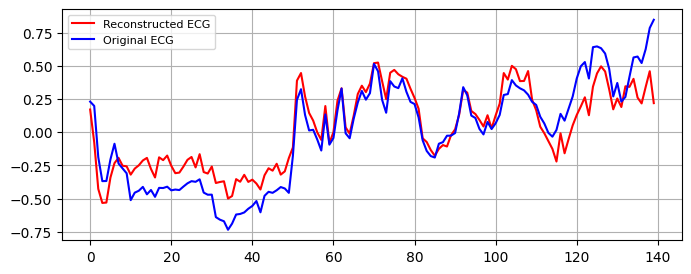

In [ ]:
model = SimpleAE(h= 10)
# TRAINING:
print("\Training results: \n")
L = train_AE(model, epochs = 100, lr = 0.01, plot = True)


print("\n Comparison between an input (ECG) and output (reconstructed ECG): \n")
fig, axs = plt.subplots(figsize = (8, 3))
axs.plot(model(x_train[0]).squeeze().detach().numpy(), 'r', label = "Reconstructed ECG")
axs.plot(x_train[0].squeeze(), 'b', label = "Original ECG")
axs.grid("minor")
_ = axs.legend(fontsize = 8)


Once we made the training of the model, we proceed to create the code implemented in the construction of the histogram of the reconstruction errors of 2 data sets:

- DATA 1 : Good ECG training data (which should have the lowest reconstruction error since it have been used in the training process)
- DATA 2 : Bad ECG training data (which should exhibits a different higher reconstruction error since it has anomalies that the model is not capable of reproduce)

we expect to use the differences in the reconstructed error distributions (RED) to classify whether there is or not an anomaly in the ECG, therefore, we made a fitting distribution process for both class (Datasets introduced in the function). After testing a wide variety of distribution types, we have been able to notice that the best and most versatile adjustment is achieved with the cauchy distribution.

The following code block has the implemented functions to compute and create the histogram of RED and the probability density function (PDF) for both class ( DATA 1 and DATA 2), and 2 random original input data and reconstructed output from the AE taken from the 2 datasets introduced in the function.

In [ ]:
dist = stats.cauchy # Chosen distribution for the fitting process
bounds = [(-100, 100), (-1, 1)] # Bounds for the parameters to use during the iteration process

# FITTING DISTRIBUTION FUNCTION
def FitDist(data) :
  res = stats.fit( dist,data, bounds) #fitting
  loc = res.params.loc #parameter loc
  scale = res.params.scale #parameter scale
  return loc, scale

# LOSS COMPARISON FUNCTION

#Creates the histograms and save the loss lists and density distribution function of the fitting process.

def loss_comparison(x1data, x2data, model, plot = True, fit = True, Seed = True, lim = 0.5) :

  if Seed :
    np.random.seed(5)

  #Naming the input data
  good_ECG = x1data
  bad_ECG = x2data

  reconst_good = model(good_ECG)
  reconst_bad = model(bad_ECG)

  Loss1, Loss2 = [], []

  # LOSS LIST CREATION
  for i in range(good_ECG.shape[0]):
    Loss1.append(loss_fn(reconst_good[i], good_ECG[i]).detach().numpy())

  for i in range(bad_ECG.shape[0]):
    Loss2.append(loss_fn(reconst_bad[i], bad_ECG[i]).detach().numpy())

  ## FITTING PROCCES

  #Fit data1
  loc1 , scale1 = FitDist(Loss1)

  #Fit data 2
  loc2 , scale2 = FitDist(Loss2)

  #Fitting results and plotting
  x = np.linspace(0,lim, 200)
  y1 = dist.pdf(x, loc = loc1, scale = scale1)
  y2 = dist.pdf(x, loc = loc2, scale = scale2)

  if plot :

    ## CREATION OF THE SUBPLOTGRID
    fig = plt.figure(figsize = (8, 4), layout= "tight")
    ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), rowspan=2)
    ax2 = plt.subplot2grid(shape=(2, 2), loc=(0, 1))
    ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 1))

    # NORMALIZED DATA HISTOGRAM
    ax1.hist(Loss1, density=True, bins=50, align='mid', alpha = 0.3, color = 'r', label = 'Data 1 reconstruction error')
    ax1.hist(Loss2, density=True, bins=50, align='mid', alpha = 0.3, color = 'm', label = 'Data 2 reconstruction error')

    # PLOTTING THE FITTING DISTRIBUTION RESULTS

    ax1.plot(x, y1 , 'r' , label = 'Data 1 RED fitting')
    ax1.plot(x, y2 , 'm' , label = 'Data 2 RED fitting')
    ax1.set_xlim([0,lim])
    ax1.set_xlabel("MSE")
    ax1.set_ylabel("Normalised frequency")

    #COMPARISON BETWEEN THE RECONSTRUCTED AND ORIGINAL DATA FOR BOTH DATA INPUTS

    imids = np.random.choice(x1data.shape[0],1)
    ax2.plot(reconst_good[imids].squeeze().detach().numpy(), 'r')
    ax2.plot(good_ECG[imids].squeeze(), 'b')
    ax2.set_title("Data 1")

    imids = np.random.choice(x2data.shape[0],1)
    ax3.plot(reconst_bad[imids].squeeze().detach().numpy(), 'r', label = "Reconstructed")
    ax3.plot(bad_ECG[imids].squeeze(), 'b', label = "Original")
    ax3.set_title("Data 2")

    ax1.legend(fontsize = 8)
    ax1.grid( 'minor')
    ax2.legend(fontsize = 8)
    ax2.grid( 'minor')
    ax3.legend(fontsize = 8)
    ax3.grid( 'minor')

  plt.show()

  return Loss1, Loss2, x, y1, y2


COMPARISON RED FOR GOOD (DATA 1) AND BAD (DATA 2) TRAIN DATA


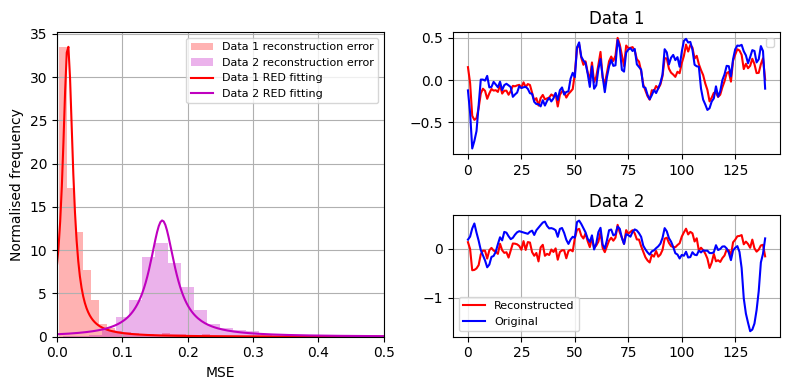

In [ ]:
print("COMPARISON RED FOR GOOD (DATA 1) AND BAD (DATA 2) TRAIN DATA")
l1, l2, x, y1, y2 = loss_comparison(x_train, bad_x_train, model)

#Parameter tuning section

We proceed to create a function used to generate a figure with 4 subplots:

- Loss vs epochs
- Final loss vs. parameter
- PDF result vs. parameter
- Difference between the mean values of the distributions vs. parameter (for DATA 1 : Good training set, and DATA 2 : Bad training set)

In [ ]:
## CREATION OF THE SUBPLOTGRID
def graphs(title, title2, variable, range) :
  fig = plt.figure(figsize = (8, 6), layout= "tight")
  ax1 = plt.subplot2grid(shape=(2, 3), loc=(0, 2))
  ax4 = plt.subplot2grid(shape=(2, 3), loc=(1, 2))
  ax2 = plt.subplot2grid(shape=(2, 3), loc=(0, 0), colspan=2)
  ax3 = plt.subplot2grid(shape=(2, 3), loc=(1, 0), colspan=2)

  # last loss plot
  ax1.plot(variable, Last_Loss,'k')
  ax1.set_xlabel(title)
  ax1.set_ylabel("Final MSE")
  ax1.grid("minor")

  # mean differences
  differences = np.array(x2) - np.array(x1)
  ax4.plot(variable, differences,'k')
  ax4.set_xlabel(title)
  ax4.set_ylabel("difference between distributions")
  ax4.grid("minor")

  X = np.concatenate((x,x),axis=1)
  Y = np.concatenate((c1,c2),axis=1)

  # Loss vs. epochs and  PDFs plots
  for i in  range :
    ax2.plot(Train_losses[i,:],'-')
    ax3.plot(X[i],Y[i], label= "\n {} = {} \n".format(title2,variable[i]))

  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("MSE")
  ax2.legend(fontsize= 8,labelspacing = 0.01)
  ax2.set_xlim([0,nepochs])
  ax2.grid("minor")

  ax3.set_xlim([0,0.4])
  ax3.set_xlabel("MSE")
  ax3.set_ylabel("Normalized frequency")
  ax3.legend(fontsize= 8,labelspacing = 0.01)
  ax3.grid("minor")
  plt.show()



Watching the plots we must be able to choose the best parameters values that satisfy the following items:

- Maximize the difference between REDs (but the REDs must also be thin).
- Minimize the final loss value (exhibing the most stable behavior in loss vs.epochs)


# HIDDEN-LAYER DIMENSION TUNNING

In [ ]:
## TUNNING OF HIDDEN-LAYER DIMENSION

h = [2, 5, 10, 20, 30, 40, 50, 60, 80] # Values of h to test
nepochs = 150

#Initializing vectos
Train_losses = np.zeros((len(h),nepochs+ 1))
Loss1, Loss2 = np.zeros((len(h),x_train.shape[0])),  np.zeros((len(h),bad_x_train.shape[0]))
x, c1, c2 = np.zeros((len(h),200)), np.zeros((len(h),200)), np.zeros((len(h),200))

Last_Loss = []
x1 = []
x2 = []

k = 0
#Computing the results for each value
for i in h :
  print("h = {}".format(i))
  model = SimpleAE(h = i)
  Train_losses[k] = train_AE(model, epochs = nepochs, lr = 0.01, plot = False)
  Loss1[k], Loss2[k], x[k], c1[k], c2[k]  = loss_comparison(x_train, bad_x_train, model, plot = False)
  Last_Loss.append(Train_losses[k,-1])
  x1.append(x[k,np.argmax(c1[k])])
  x2.append(x[k,np.argmax(c2[k])])
  k += 1

h = 2
Run Time: 1.3564844131469727	
h = 5
Run Time: 1.383927822113037	
h = 10
Run Time: 1.1623291969299316	
h = 20
Run Time: 1.541283130645752	
h = 30
Run Time: 1.962214469909668	
h = 40
Run Time: 1.5524704456329346	
h = 50
Run Time: 4.343237638473511	
h = 60
Run Time: 4.989102363586426	
h = 80
Run Time: 4.45950722694397	



 HIDDEN-LAYER DIMENSION TUNNING: 



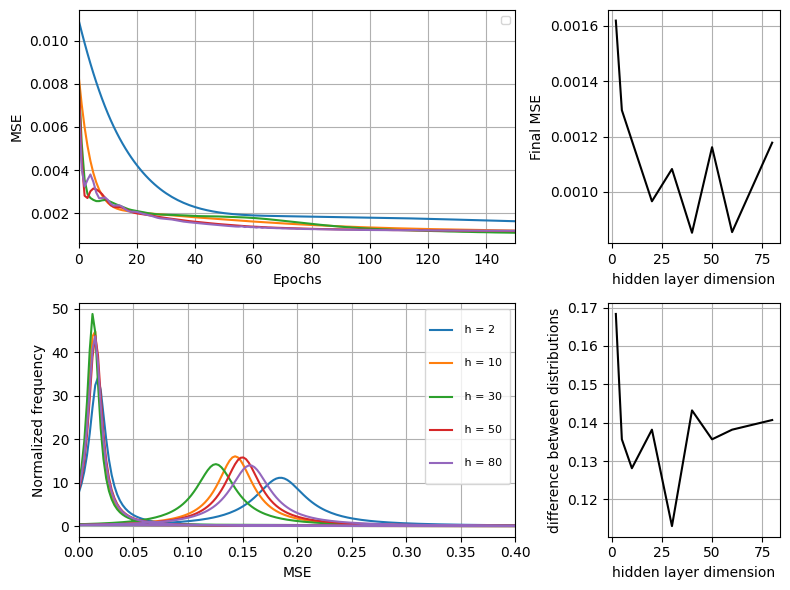

In [ ]:
print("\n HIDDEN-LAYER DIMENSION TUNNING: \n")
graphs("hidden layer dimension", "h", h,[0,2,4,6,8])

Even though we see that for values of h > 10 the final loss is lower, we start to see an unstable behavior in the loss vs. epochs, which may create some undesirable convergence problems. In addtion, we have a maximum value in the separation of the distributions for some $h < 10$, but the width of RED for both ECGs are higher, which can induce less accuracy. So that, we select the value of $h=10$ as and optimal hyperparameter.

# LEARNING RATE TUNNING

In [ ]:
## TUNNING OF LEARNING RATE

lr = [0.0001,0.0005,0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1] # Values of learning rate to test
nepochs = 150

Train_losses = np.zeros((len(lr),nepochs + 1))
Loss1 = np.zeros((len(lr),x_train.shape[0]))
Loss2 = np.zeros((len(lr),bad_x_train.shape[0]))
x, c1, c2 = np.zeros((len(lr),200)), np.zeros((len(lr),200)), np.zeros((len(lr),200))

Last_Loss = []
x1 = []
x2 = []

#Computing the results for each value
k = 0
for i in lr :
  print("learning rate = {}".format(i))
  model = SimpleAE(h = 10)
  Train_losses[k,:] = train_AE(model, epochs = nepochs, lr = i, plot = False)
  Loss1[k,:], Loss2[k,:], x[k], c1[k], c2[k]  = loss_comparison(x_train, bad_x_train, model, plot = False)
  Last_Loss.append(Train_losses[k,-1])
  x1.append(x[k,np.argmax(c1[k])])
  x2.append(x[k,np.argmax(c2[k])])
  k += 1


learning rate = 0.0001
Run Time: 1.1472327709197998	
learning rate = 0.0005
Run Time: 1.1416511535644531	
learning rate = 0.001
Run Time: 1.1326072216033936	
learning rate = 0.005
Run Time: 1.2063353061676025	
learning rate = 0.01
Run Time: 1.6247663497924805	
learning rate = 0.05
Run Time: 1.1478550434112549	
learning rate = 0.1
Run Time: 1.146909475326538	
learning rate = 0.5
Run Time: 1.172529697418213	
learning rate = 1
Run Time: 1.158991813659668	


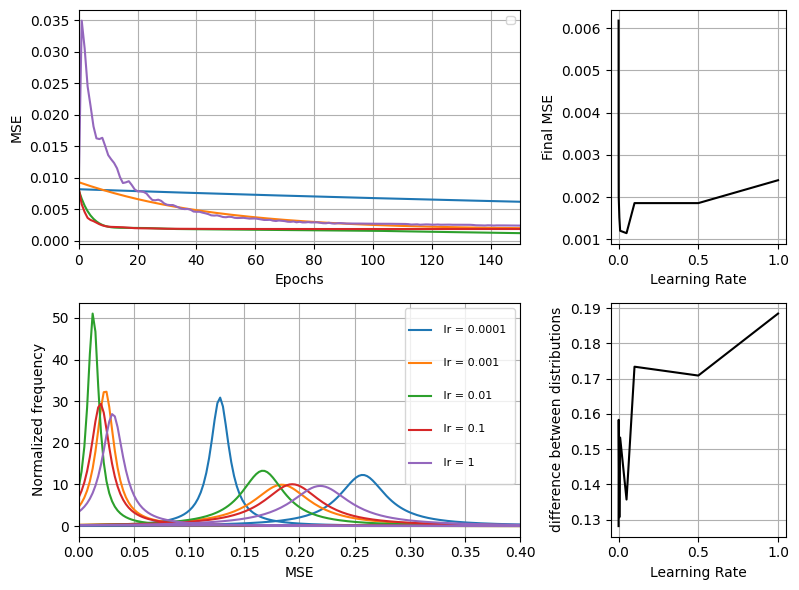

In [ ]:
graphs("Learning Rate", "lr", lr,[0,2,4,6,8])

In this case, we see that the larger the learning rate, the greater the distances between REDs, nevertheless, the stabilty of loss vs. epochs decreases. Therefore, we conclude that the best neutral value for learning rate should be around $lr = 0.1$ that is the selected value.

# ANOMALY DETECTION

Once we chose the parameters of the model and training functions, we re-train the model with these values to create the anomaly detection function.

Run Time: 1.598201036453247	


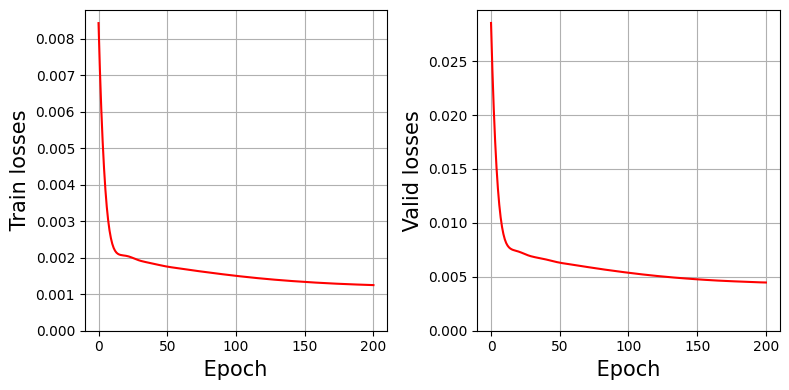

In [ ]:
model = SimpleAE(h = 10)
L = train_AE(model, epochs = 200, lr = 0.01, plot = True)


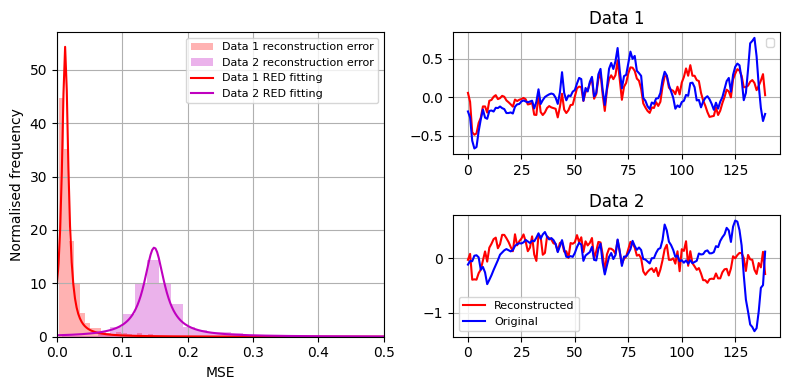

In [ ]:
L1, L2, f, f2, f3 = loss_comparison(x_train, bad_x_train, model)

We verify that the separation between REDs is done and we decide a 95% significance value to decide is the ECG is good or not, i.e., we search the MSE where we have a 95% of probabilty of a MSE to fall in the good ECGs RED.

In [ ]:
loc , scale = FitDist(L1)

#Fitting results and plotting
threshold_MSE = dist.ppf(0.95, loc = loc, scale = scale)
print("The threshold MSE is :", threshold_MSE)

The threshold MSE is : 0.016240644457744893


Thus, if the MSE introduced in the function is above this MSE threshold it is classify as ECG with anomalies, if not it is a normal ECG.

In [ ]:
def AnomalyDetection(x, model, threshold_MSE):

    ECG_original = x
    ECG_reconst = model(ECG_original)
    loss = loss_fn(ECG_reconst,ECG_original)
    if loss > threshold_MSE :
      return 0
    else :
      return 1

without = AnomalyDetection(good_x_test[0], model, threshold_MSE)
with_ = AnomalyDetection(bad_x_test[0], model, threshold_MSE)

print("With Anomaly : ", with_)
print("Without Anomaly : ", without)

With Anomaly :  0
Without Anomaly :  1


We create a Test for the anomaly detection using the labels in the test data to compare whether our model is having a good performance or not.

In [ ]:
def TestAnomalyDetection(threshold_MSE, model):

  original_label = y_test.detach().numpy()
  reconst_label = []

  total_labels = x_test.shape[0]

  for i in range(total_labels) :
    reconst_label.append(AnomalyDetection(x_test[i], model, threshold_MSE))


  reconst_label = th.FloatTensor(reconst_label).detach().numpy()

  total_good_labels = np.sum(original_label)


  indx = original_label == reconst_label
  well_good_labeled = np.sum(original_label[indx])

  aux = np.ones_like(original_label)
  well_labeled = np.sum(aux[indx])
  accuracy = well_labeled/total_labels

  print("ANOMALY DETECTION TEST")

  print("Original bad ECG percentage: ",(well_good_labeled/total_labels))

  print("Reconstructed bad ECG percentage: ",(total_good_labels/total_labels))

  print("Accuracy detecting anomalies data: ",accuracy)

  return reconst_label

L = TestAnomalyDetection(threshold_MSE, model)

ANOMALY DETECTION TEST
Original bad ECG percentage:  0.567
Reconstructed bad ECG percentage:  0.584
Accuracy detecting anomalies data:  0.767


So, we are detecting more ECG than there are in the original data but the accuracy in the reconstructed labels compared with the original labels are higher than the 95%. So, as we are detecting more bad ECG, a great part of the rest percentage in the accuracy may be the error labeling this data as bad ECG; however, is better to have this good data labeled as bad one (kind of suspicious data) than label bad data as good, which may have big consequences for further aplications, as medicine.


 COMPARISON BETWEEN THE RECONSTRUCTED ERROR OF THE TRAINING DATA AND THE VALIDATION DATA

 Good test data


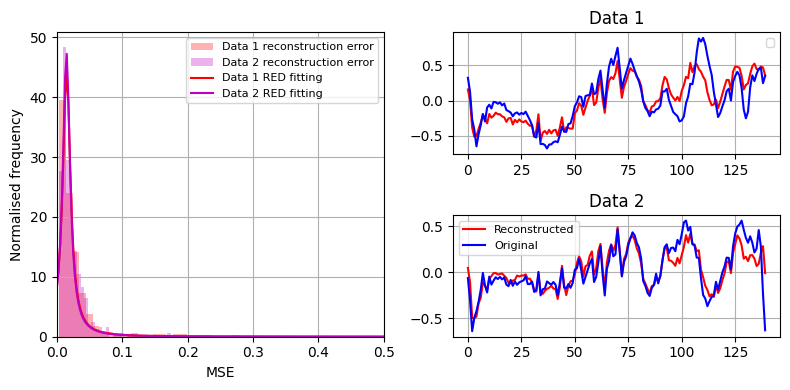


 Bad test data


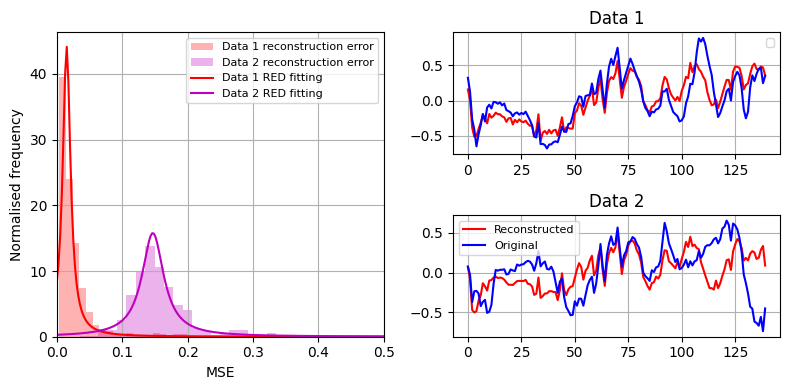

In [ ]:
print("\n COMPARISON BETWEEN THE RECONSTRUCTED ERROR OF THE TRAINING DATA AND THE VALIDATION DATA")

print("\n Good test data")
L = loss_comparison(x_train, good_x_test, model)

print("\n Bad test data")

L = loss_comparison(x_train, bad_x_test, model)

Here we can appreciate the differences in the REDs for the good training data (Data 1) and (Data 2):
- 1) Good test data
- 2) Bad test data
Where is noticeable the classification. We can see the projection in 2D-dimension made by the bottle neck layer as follows.


Text(0.5, 1.0, 'Testing set')

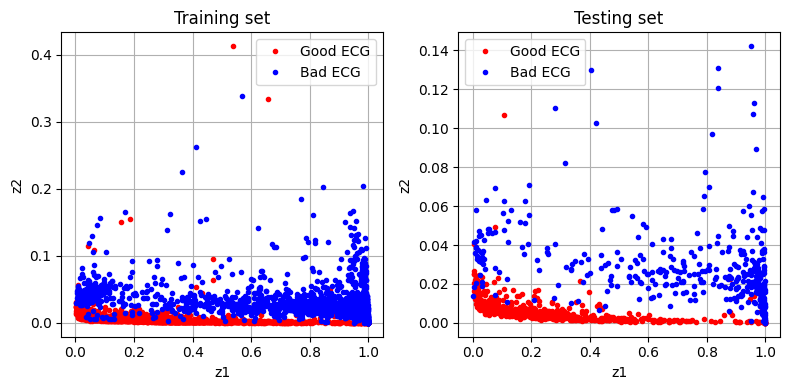

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (8, 4), layout= "tight")

z1 = model.Encoder(x_train).squeeze().detach().numpy()
z2 = model.Encoder(bad_x_train).squeeze().detach().numpy()

ax[0].plot(z1[:,0],z1[:,1],'r .', label = "Good ECG")
ax[0].plot(z2[:,0],z2[:,1],'b .', label = "Bad ECG")
ax[0].grid("minor")
ax[0].set_xlabel("z1")
ax[0].set_ylabel("z2")
ax[0].legend()
ax[0].set_title("Training set")

z1 = model.Encoder(good_x_test).squeeze().detach().numpy()
z2 = model.Encoder(bad_x_test).squeeze().detach().numpy()

ax[1].plot(z1[:,0],z1[:,1],'r .', label = "Good ECG")
ax[1].plot(z2[:,0],z2[:,1],'b .', label = "Bad ECG")
ax[1].grid("minor")
ax[1].set_xlabel("z1")
ax[1].set_ylabel("z2")
ax[1].legend()
ax[1].set_title("Testing set")



As we can see, the 2D-projection made with the encoder let us watch explicitely how the information is distributed in the bottle-neck. In this layer, the input data is compressed from a dimension of 140 to 2. Therefore, as it is the fundamental pillar to decompress and reconstruct the ECG, the most important caracteristics of the data must be saved and grouped in this layer; thus, the more spaced the sets are, the better the determination of the anomalies or differences between the sets will be.

In the figure we appreciate a separation between blue and red sets (Good and Badd ECGs datasets), however, the border between them are close one from the other due to the nature of the data and the model.

In conclusion, as the previous results showed, this simple AE is a powerful tool in the field of anomalies detection since it does not need a huge ammount of computing memmory and the results showed a 95% accuracy with the training sets. However, another algorithms should be used to increase the separation or differentiation of the bad and good ECGs to increase the accuracy and performance of the anomaly detection.

# Convolutional Auto-encoder

The input are time series. Like images, we can efficiently take into account the specifities of the inputs with convolutions: here it a time serie, we need 1D convolution.

The idea is:
- for the encoder use Conv1d, and pooling
- for the decoder, the opposite is ConvTranspose1d

Look at the documentation of Pytorch and design a convolutional Auto-encoder for ECGs.
Like images, you can either do several convolution in parallel but here you can also try to pipe them to reduce progressively the input dimenion.



As recommended, we made a simple convolutional auto-encoder that is made of ⁉

## Encoder :
- 1-D convolution ( N x 140 → N x 140 )
- MaxPooling with stride = 2 ( N x 140 → N x 70 )

## Decoder
- 1-D Transposed convolution = 2 ( N x 70 → N x 140 )
- Tanh activation function = 2 ( N x 140 → N x 140 )

In [ ]:
### write the class

class ConvAE(nn.Module):
    # TODO :
    def __init__(self):
        super(ConvAE, self).__init__()

        self.conv = nn.Conv1d(in_channels = 1, out_channels = 1,
                              kernel_size = 3 , padding = 1)
        # TODO: add the rest
        self.maxpool = nn.MaxPool1d(kernel_size = 3 , stride = 2, padding=1)

        self.deconv = nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size  = 4 , stride = 2, padding=1)


        self.activ = nn.Tanh()

    def forward(self,x) :
      #Enconder
        x = self.conv(x)
        x = self.maxpool(x)
      #Decoder
        x = self.deconv(x)
        x = self.activ(x)

        return  x

We test this convolutional AE and we find:

CONVOLUTIONAL 1
Run Time: 6.561962604522705	


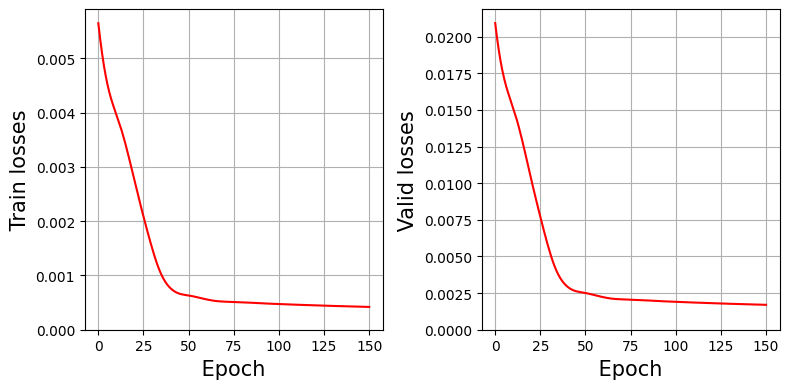

In [ ]:
print("CONVOLUTIONAL 1")
model = ConvAE()
L = train_AE(model, epochs = 150, lr = 0.01, plot = True)


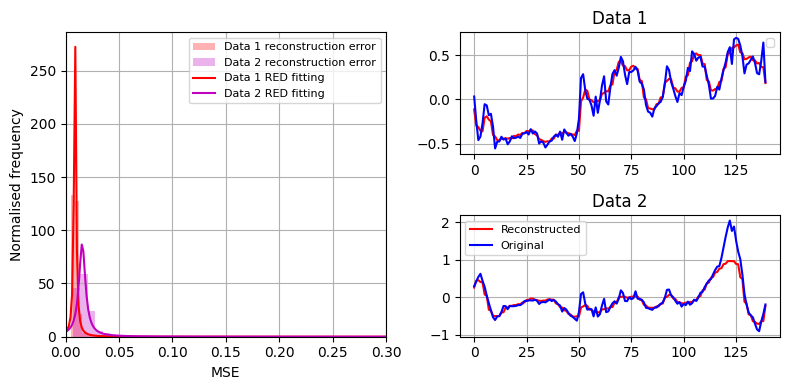

In [ ]:
L1, L2, f, f1, f2 = loss_comparison(x_train, bad_x_train, model, lim = 0.3)
loc , scale = FitDist(L1)

In [ ]:
Threshold = dist.ppf(0.95, loc = loc, scale = scale)
L = TestAnomalyDetection(Threshold,model)

ANOMALY DETECTION TEST
Original bad ECG percentage:  0.567
Reconstructed bad ECG percentage:  0.584
Accuracy detecting anomalies data:  0.767


As we see, we achieve an accuracy of 76%, which is low for our purpose but, since it has a simple structure, is a remarkable performance. However, because of the nature of convolution, the reconstructed ECG is a representation with less oscilations, such as a smoothing or noise reduction process. In order to vary this nature, we create another convolutional layer that decrease in dimensions to a bottle neck dimension of 18 (to be similar as the simple AE previously made) as follows:

#Encoder
- Conv1D (N x 140) → MaxPool1D (N x 70)
- Conv1D (N x 140) → MaxPool1D (N x 35)
- Conv1D (N x 140) → MaxPool1D (N x 18)

#Decoder
- ConvTranspose1D (N x 36)
- ConvTranspose1D (N x 70)
- ConvTranspose1D (N x 140) → Tanh  (N x 140)

In [ ]:
### write the class
class ConvAE2(nn.Module):
    # TODO :
    def __init__(self):
        super(ConvAE2, self).__init__()

        self.conv = nn.Conv1d(in_channels = 1, out_channels = 1,
                              kernel_size = 3 , padding = 1)
        # TODO: add the rest
        self.maxpool = nn.MaxPool1d(kernel_size = 3 , stride = 2, padding=1)

        self.deconv1 = nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size  = 4 , stride = 2, padding=1)

        self.deconv2 = nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size  = 2 , stride = 2, padding=1)

        self.activ = nn.Tanh()

    def forward(self,x) :
      #Enconder
        x = self.conv(x)
        x = self.maxpool(x)
        x = self.conv(x)
        x = self.maxpool(x)
        x = self.conv(x)
        x = self.maxpool(x)
      #Deconder
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv1(x)
        x = self.activ(x)

        return  x

And we make the training and validation process:

CONVOLUTIONAL 2
Run Time: 11.926603078842163	


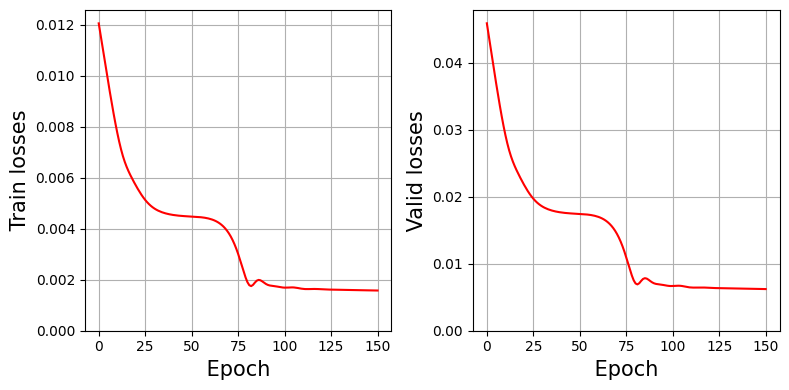

In [ ]:
print("CONVOLUTIONAL 2")
model = ConvAE2()
L = train_AE(model, epochs = 150, lr = 0.01, plot = True)

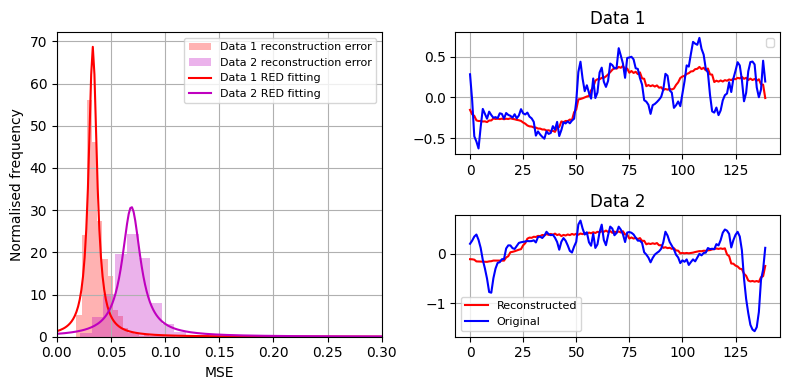

ANOMALY DETECTION TEST
Original bad ECG percentage:  0.53
Reconstructed bad ECG percentage:  0.584
Accuracy detecting anomalies data:  0.9


In [ ]:
L1, L2, f, f1, f2 = loss_comparison(x_train, bad_x_train, model, lim = 0.3)
loc , scale = FitDist(L1)
y = dist.ppf(0.9, loc = loc, scale = scale)
L = TestAnomalyDetection(y, model)

Even though we increased the accuracy until 90%, we can see that the separation between the distribution (and REDs width) does not give the confidence to continue with this approach; the results shows that the reconstruction of the time series is even more smoothed, reason why it is difficult to improve its performance.

As another approach to treat these timeseries we will use Temporal Convolutional Networks Auto-Encoder (TCN-AE). TCN-AE uses so-called dilated convolutional layers to naturally create a large receptive field and process a
time series signal at different time scales. [1]

TCN-AE consists of two parts, an encoder, and a decoder, which are both trained
simultaneously and learn to find a compressed representation of
the input time series (encoder) and reconstruct the original input
again (decoder). After training TCN-AE, we use the reconstruction
error as an indicator for abnormal behavior as we previouly did with the Simple AE.

The TCN-AE proposed here is inspired in Thill, Markus' work [1]. It differs from conventional autoencoders in that it combines causal and sparse convolutional layers instead of fully connected layers. Consequently, the network is more flexible for variable input sizes and more sensitive to temporal correlation [2]. The central idea is to encode the input sequence compressively for creating a compact representation, which forces the network to learn the most representative patterns in the original input and to accurately reconstruct the original input. Conceptually, the TCN-AE learns to ignore data noise and trains the network for the purpose of minimizing the reconstruction loss of the input sequence. As a result, the anomalous data will have a larger reconstruction loss than normal data.

The TCN-AE proposed is similar to the one proposed in [2].

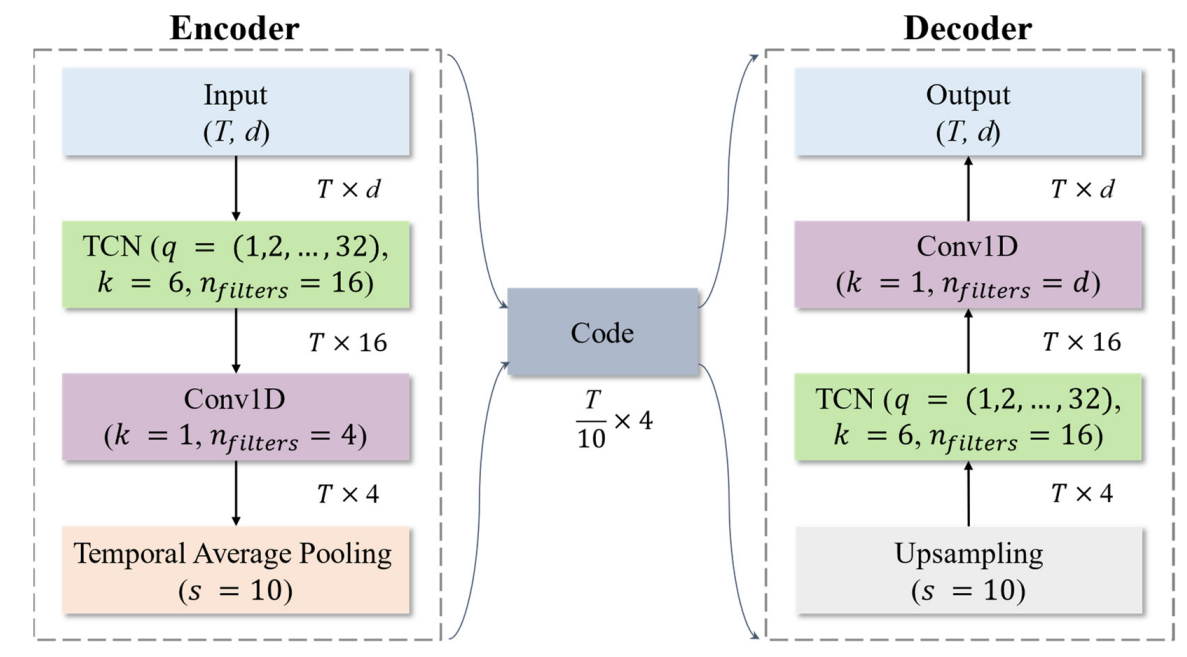

In [ ]:
### write the class

def TCN(in_ch, n_filter, No_dilation_layers) :

  sequential = []
  for i in range(No_dilation_layers) :
    sequential.append(nn.Conv1d(in_channels = in_ch , out_channels = n_filter,
                              kernel_size = 3 ,padding = 2**i , dilation = 2**i))
    in_ch = n_filter

  return nn.Sequential(*sequential)



class TCN_AE(nn.Module):
    # TODO :
    def __init__(self,  n_filt = 12,  dil_layer = 6):
        super(TCN_AE, self).__init__()

        self.TCN1 = TCN(in_ch=1,  n_filter = n_filt, No_dilation_layers = dil_layer)

        self.conv1 = nn.Conv1d(in_channels = n_filt, out_channels = 4,
                              kernel_size = 1)

        self.avgpool = nn.AvgPool1d(kernel_size = 11 , stride = 10, padding=1)

        self.ReLU = nn.ReLU()

        #self.upsampling = nn.Upsample(scale_factor=10)
        self.upsampling = nn.ConvTranspose1d(in_channels = 4, out_channels = 4, kernel_size  = 12 , stride = 10, padding=1)

        self.TCN2 = TCN(in_ch = 4, n_filter = n_filt, No_dilation_layers = dil_layer)

        self.conv2 = nn.Conv1d(in_channels = n_filt, out_channels = 1,
                              kernel_size = 1)
        self.activ = nn.Tanh()

    def forward(self,x) :
      # Encoder
        x = self.TCN1(x)
        x = self.ReLU(x)
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.avgpool(x)
      # Decoder
        x = self.upsampling(x)
        x = self.TCN2(x)
        x = self.conv2(x)
        x = self.activ(x)

        return  x


We do the tunning of the n_filters and Number of dilation layers that are te hyperparameters of this TCN-AE.

In [ ]:
print("TCN AE")

n = [2, 4, 8, 12, 15,20]
nepochs = 10

Train_losses = np.zeros((len(n),nepochs+ 1))
Loss1, Loss2 = np.zeros((len(n),x_train.shape[0])),  np.zeros((len(n),bad_x_train.shape[0]))
x, c1, c2 = np.zeros((len(n),200)), np.zeros((len(n),200)), np.zeros((len(n),200))

Last_Loss = []
x1 = []
x2 = []

k = 0
for i in n :
  print("n_filt  = {}".format(i))
  model = TCN_AE(n_filt = i)
  Train_losses[k] = train_AE(model, epochs = nepochs, lr = 0.01, plot = False)
  Loss1[k], Loss2[k], x[k], c1[k], c2[k]  = loss_comparison(x_train, bad_x_train, model, plot = False)
  Last_Loss.append(Train_losses[k,-1])
  x1.append(x[k,np.argmax(c1[k])])
  x2.append(x[k,np.argmax(c2[k])])
  k += 1

TCN AE
n_filt  = 2
Run Time: 4.147425651550293	
n_filt  = 4
Run Time: 4.387932300567627	
n_filt  = 8
Run Time: 8.091888427734375	
n_filt  = 12
Run Time: 12.004199028015137	
n_filt  = 15
Run Time: 14.14236330986023	
n_filt  = 20
Run Time: 22.398358583450317	


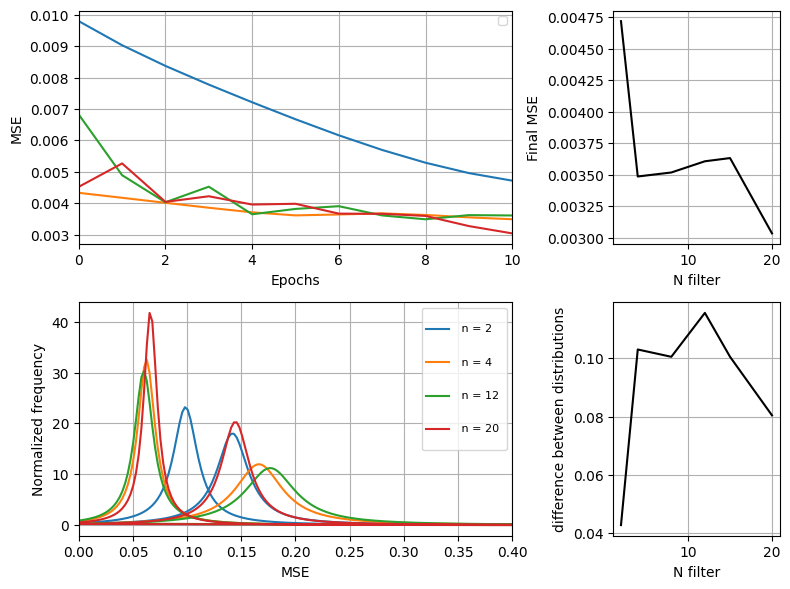

In [ ]:
graphs("N filter", "n", n,[0,1,3,5])

In [ ]:
n = [1, 3, 5, 7, 10]
nepochs = 10

Train_losses = np.zeros((len(n),nepochs+1))
Loss1, Loss2 = np.zeros((len(n),x_train.shape[0])),  np.zeros((len(n),bad_x_train.shape[0]))
x, c1, c2 = np.zeros((len(n),200)), np.zeros((len(n),200)), np.zeros((len(n),200))

Last_Loss = []
x1 = []
x2 = []

k = 0
for i in n :
  print("No dilation layers = {}".format(i))
  model = TCN_AE(dil_layer = i)
  Train_losses[k] = train_AE(model, epochs = nepochs, lr = 0.01, plot = False)
  Loss1[k], Loss2[k], x[k], c1[k], c2[k]  = loss_comparison(x_train, bad_x_train, model, plot = False)
  Last_Loss.append(Train_losses[k,-1])
  x1.append(x[k,np.argmax(c1[k])])
  x2.append(x[k,np.argmax(c2[k])])
  k += 1

No dilation layers = 1
Run Time: 2.013002395629883	
No dilation layers = 3
Run Time: 5.838803052902222	
No dilation layers = 5
Run Time: 9.121459007263184	
No dilation layers = 7
Run Time: 14.749911308288574	
No dilation layers = 10
Run Time: 19.616894245147705	


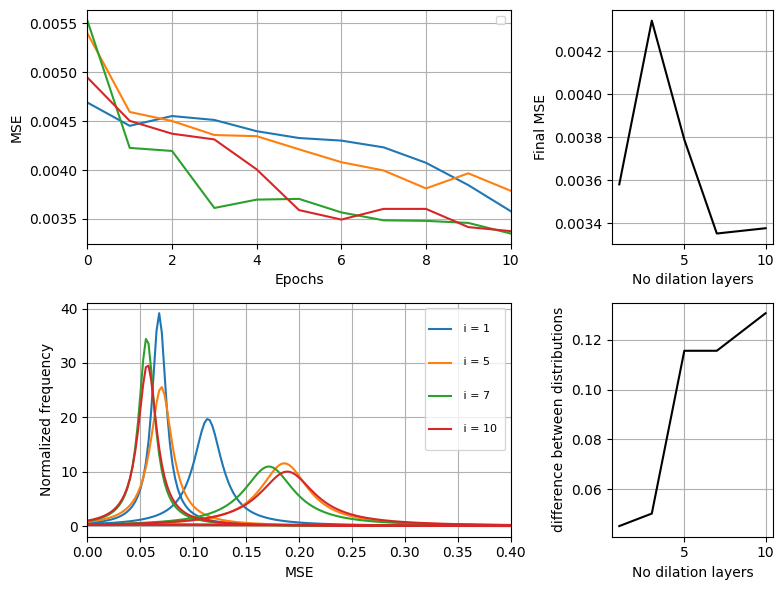

In [ ]:
graphs("No dilation layers", "i", n,[0,2,3,-1])

CONVOLUTIONAL 3
Run Time: 165.54572010040283	


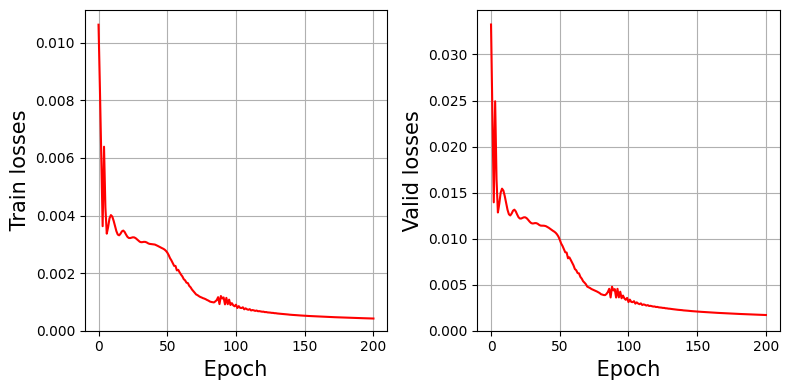

In [ ]:
print("CONVOLUTIONAL 3")
model = TCN_AE(dil_layer = 7, n_filt = 8)
L = train_AE(model, epochs = 200, lr = 0.01, plot = True)

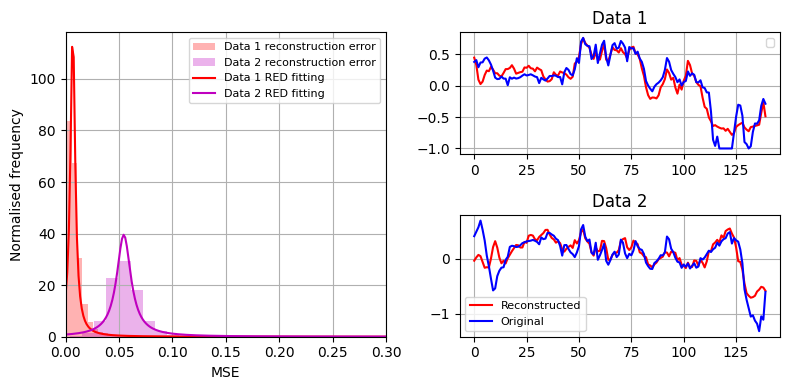

In [ ]:
L1, L2, f, f1, f2 = loss_comparison(x_train, bad_x_train, model, lim = 0.3)
loc , scale = FitDist(L1)

In [ ]:

threshold = dist.ppf(0.95, loc = loc, scale = scale)
L = TestAnomalyDetection(threshold, model)

ANOMALY DETECTION TEST
Original bad ECG percentage:  0.551
Reconstructed bad ECG percentage:  0.584
Accuracy detecting anomalies data:  0.962


As expected, this network requires more computing memmory than the simple AE but, compared with the other convolutional auto encoders, we see that there is no more smoothing in the reconstruction signal and this allow to have a better distinction in anomalies, achieving an accuracy of above 96%.

# Annexes

In [ ]:

x_train = x_train.view(-1,1,140)

print("Original Data:")
x = x_train
print(x.shape )

conv = nn.Conv1d(in_channels = 1, out_channels = 1,
                              kernel_size = 3 , padding = 1)
x = conv(x_train)

print("Data after convolution:")
print(x.shape)

maxpool = nn.MaxPool1d(kernel_size = 3 , stride = 2, padding=1)

x = maxpool(x)

print("Data after pooling:")
print(x.shape)

x = conv(x)

print("Data after convolution:")
print(x.shape)

x = maxpool(x)

print("Data after pooling:")
print(x.shape)

x = conv(x)

print("Data after convolution:")
print(x.shape)

x = maxpool(x)

print("Data after pooling:")
print(x.shape)

deconv= nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size  = 4 , stride = 2, padding=1)

x = deconv(x)

print("Data after convtrans:")
print(x.shape)

deconv= nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size  = 2 , stride = 2, padding=1)

x = deconv(x)

print("Data after convtrans:")
print(x.shape)

deconv= nn.ConvTranspose1d(in_channels = 1, out_channels = 1, kernel_size  = 4 , stride = 2, padding=1)

x = deconv(x)

print("Data after convtrans:")
print(x.shape)

Original Data:
torch.Size([2335, 1, 140])
Data after convolution:
torch.Size([2335, 1, 140])
Data after pooling:
torch.Size([2335, 1, 70])
Data after convolution:
torch.Size([2335, 1, 70])
Data after pooling:
torch.Size([2335, 1, 35])
Data after convolution:
torch.Size([2335, 1, 35])
Data after pooling:
torch.Size([2335, 1, 18])
Data after convtrans:
torch.Size([2335, 1, 36])
Data after convtrans:
torch.Size([2335, 1, 70])
Data after convtrans:
torch.Size([2335, 1, 140])


In [ ]:
n_filt = 5
dil_layer = 3

x = x_test[0]
print(x.shape)
s = TCN(in_ch= 1, n_filter = n_filt, No_dilation_layers = dil_layer)

x = s(x)
print(x.shape)

s = nn.Conv1d(in_channels = n_filt, out_channels = 4,
                              kernel_size = 1)

x = s(x)
print(x.shape)

s = nn.AvgPool1d(kernel_size = 11 , stride = 10, padding=1)

x = s(x)
print(x.shape)

#s = nn.Upsample(scale_factor=10)
s = nn.ConvTranspose1d(in_channels = 4, out_channels = 4, kernel_size  = 12 , stride = 10, padding=1)
x = s(x)
print(x.shape)

s = TCN(in_ch = 4, n_filter = n_filt, No_dilation_layers = dil_layer)

x = s(x)
print(x.shape)

s = nn.Conv1d(in_channels = n_filt, out_channels = 1,
                              kernel_size = 1)

x = s(x)
print(x.shape)



torch.Size([1, 140])
torch.Size([5, 140])
torch.Size([4, 140])
torch.Size([4, 14])
torch.Size([4, 140])
torch.Size([5, 140])
torch.Size([1, 140])


#References

[1] Thill, M., Konen, W., Wang, H., & Bäck, T. H. W. (2021). Temporal convolutional autoencoder for unsupervised anomaly detection in time series. Applied Soft Computing, 112. doi:10.1016/j.asoc.2021.107751

[2] Zheng, X.; Yu, D.; Xie, C.; Wang, Z. Outlier Detection of Crowdsourcing Trajectory Data Based on Spatial and Temporal Characterization. Mathematics 2023, 11, 620. https://doi.org/10.3390/math11030620
